# Waymo Open Dataset Tutorial

Before running this jupyter notebook, perform the following installation steps.

### Clone Waymo Open Dataset
1. `git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od`
2. `cd waymo-od && git branch -a`
3. `git checkout remotes/origin/master`

### Create Conda Environment
1. `conda create --name waymo-od python=3.7`
2. `conda activate waymo-od`
3. `pip3 install waymo-open-dataset-tf-2-1-0==1.2.0`
4. `conda install ipykernel`
5. `ipython kernel install --user --name=waymo-od`

### Install Bazel
1. `sudo apt install build-essential`
2. `sudo apt-get install --assume-yes pkg-config zip g++ zlib1g-dev unzip python3 python3-pip`
3. `wget https://github.com/bazelbuild/bazel/releases/download/0.28.0/bazel-0.28.0-installer-linux-x86_64.sh`
4. `sudo bash ./bazel-0.28.0-installer-linux-x86_64.sh`

### Build Waymo Open Dataset
1. `cd waymo-od && ./configure.sh && cat .bazelrc && bazel clean`
2. `bazel build ... --show_progress_rate_limit=10.0`

### Download Data Segment(s)
You can download data segments from Waymo's website https://waymo.com/open/download/
Put the .tfrecord files in src/data

## Import Necessary Python Libraries

In [1]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

2022-02-28 16:51:14.881423: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-02-28 16:51:14.882656: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6


If you get an error message "ImportError: cannot import name 'dataset_pb2' from 'waymo_open_dataset'", run the following commands:
1. `protoc ./waymo_open_dataset/dataset.proto --python_out=.`
2. `protoc ./waymo_open_dataset/label.proto --python_out=.`

## Read the Frames from a Data Segment

In [2]:
FILENAME = 'data/training_segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')

frames = []
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    frames.append(frame)
    
print('Total frames ', len(frames))

2022-02-28 16:51:21.398125: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-02-28 16:51:21.438255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 16:51:21.438647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.65GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-28 16:51:21.438803: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64:/opt/ros/melodic/lib
2022-02-28 16:51:21.438832: I tensorflow/stream_executo

Total frames  198


In [3]:
(range_images, camera_projections,
 range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
    frames[0])

## Examine the Context of the First Frame

In [4]:
print(frames[0].context)

name: "10017090168044687777_6380_000_6400_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2059.612011552946
  intrinsic: 2059.612011552946
  intrinsic: 952.4121898799498
  intrinsic: 634.5872082485005
  intrinsic: 0.03545287376426267
  intrinsic: -0.33830085391165776
  intrinsic: 1.9229596190070855e-05
  intrinsic: 0.0007138551068011635
  intrinsic: 0.0
  extrinsic {
    transform: 0.9999785086634438
    transform: 0.003142074430868787
    transform: 0.005754092413724721
    transform: 1.5391467608686606
    transform: -0.0032444997400664865
    transform: 0.999834903267396
    transform: 0.017878462733512377
    transform: -0.02402951085443307
    transform: -0.005696966971249904
    transform: -0.017896747652793314
    transform: 0.9998236099386635
    transform: 2.115778469674332
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  int

## Read the Vehicle's Pose in the First Frame and Last Frames

In [10]:
pose0 = frames[0].pose
posef = frames[-1].pose

pose0_x = pose0.transform[3]
pose0_y = pose0.transform[7]
pose0_z = pose0.transform[11]

posef_x = posef.transform[3]
posef_y = posef.transform[7]
posef_z = posef.transform[11]

distance_traveled = np.sqrt((posef_x-pose0_x)**2 + (posef_y-pose0_y)**2 + (posef_z-pose0_z)**2)
total_time = (frames[-1].timestamp_micros - frames[0].timestamp_micros) * 1e-6
average_speed = distance_traveled / total_time

print('Distance Traveled in this Sequence:', distance_traveled, ' m')
print('Total Time in this Sequence:', total_time, ' s')
print('Average Speed:', average_speed, ' m/s')


Distance Traveled in this Sequence: 109.55562954407581  m
Total Time in this Sequence: 19.702147  s
Average Speed: 5.560593449235548  m/s


## Check the Labels in this Frame

In [32]:
print(frames[0].camera_labels)
print(frames[0].laser_labels)
print(frames[0].projected_lidar_labels)

[name: FRONT
labels {
  box {
    center_x: 1466.5519800000002
    center_y: 492.6402
    width: 109.89666
    length: 240.63579000000004
  }
  type: TYPE_VEHICLE
  id: "12ba81ee-9cee-4134-94ca-df9ed01e0ff1"
}
labels {
  box {
    center_x: 1109.07204
    center_y: 536.8515
    width: 156.00273000000004
    length: 178.73997000000008
  }
  type: TYPE_VEHICLE
  id: "2ab9ff55-a510-435b-a729-884444e67249"
}
labels {
  box {
    center_x: 1181.70489
    center_y: 519.16698
    width: 95.37008999999995
    length: 61.89581999999996
  }
  type: TYPE_VEHICLE
  id: "470e3826-ecd2-425c-80ca-33f3d8c876a6"
}
labels {
  box {
    center_x: 1006.1228699999999
    center_y: 486.95588999999995
    width: 39.15857999999997
    length: 28.421550000000025
  }
  type: TYPE_VEHICLE
  id: "98fcf17a-d19e-4c3b-bbc0-54ae2d1fcc15"
}
labels {
  box {
    center_x: 1380.02415
    center_y: 603.8000400000001
    width: 127.58118000000002
    length: 361.26947999999993
  }
  type: TYPE_VEHICLE
  id: "fb06fe05-95ee

## Visualize Camera Images and Camera Labels

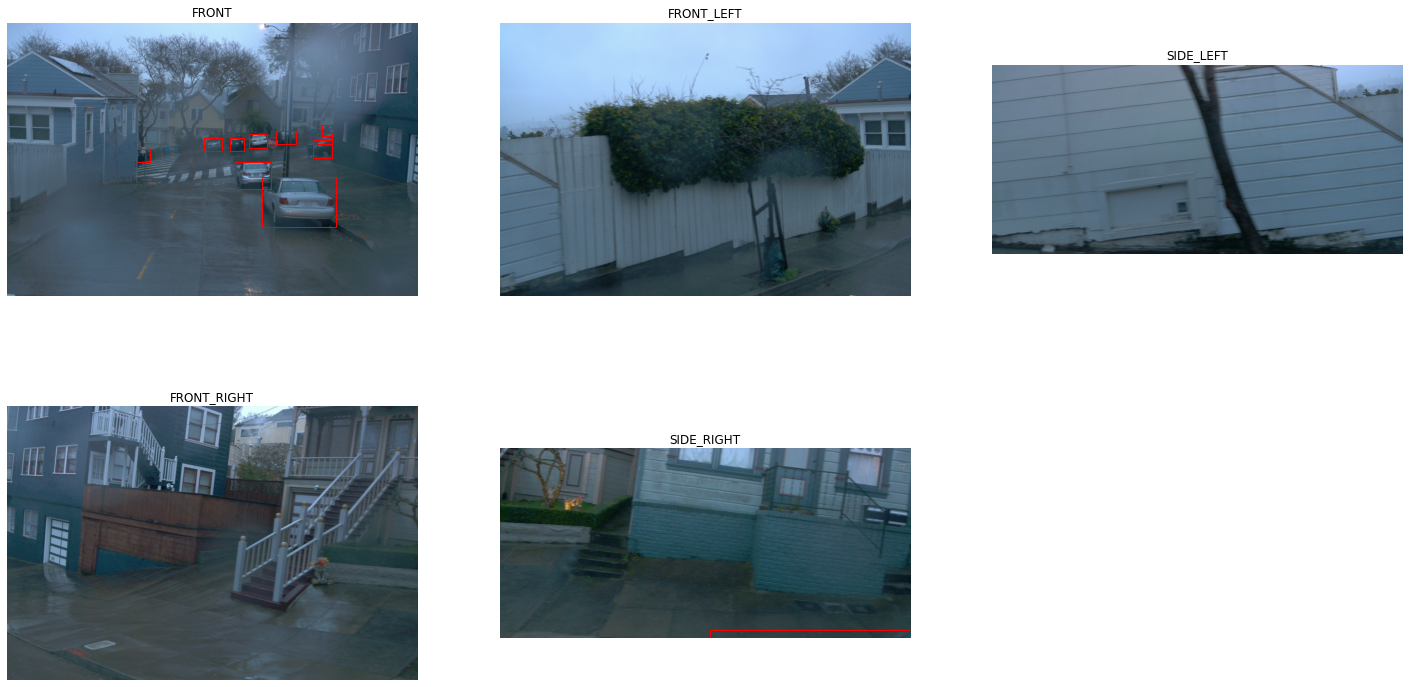

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, frame_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frames[-1].images):
  show_camera_image(image, frames[-1].camera_labels, [3, 3, index+1])

## Read the Vehicle's Velocity in the First Frame

In [7]:
# Note that the velocities differ slightly between images in the same frame due to slight differences in the pose timestamp
print(frames[0].images[0].velocity)
print(frames[0].images[0].pose_timestamp)

print(frames[0].images[1].velocity)
print(frames[0].images[1].pose_timestamp)

print(frames[0].images[2].velocity)
print(frames[0].images[2].pose_timestamp)

print(frames[0].images[3].velocity)
print(frames[0].images[3].pose_timestamp)

print(frames[0].images[4].velocity)
print(frames[0].images[4].pose_timestamp)

v_x: 5.765130996704102
v_y: 1.3712701797485352
v_z: -1.3291109800338745
w_x: -0.010016016662120819
w_y: -0.014922491274774075
w_z: 0.10547474026679993

1550083467.40108
v_x: 5.757565498352051
v_y: 1.392408847808838
v_z: -1.327417016029358
w_x: 0.0034008920192718506
w_y: -0.011683915741741657
w_z: 0.09937526285648346

1550083467.3810802
v_x: 5.762587547302246
v_y: 1.3898952007293701
v_z: -1.3308465480804443
w_x: 0.00532871950417757
w_y: -0.012515503913164139
w_z: 0.0987260490655899

1550083467.3710794
v_x: 5.764106750488281
v_y: 1.3746941089630127
v_z: -1.330061674118042
w_x: -0.01475585252046585
w_y: -0.016970766708254814
w_z: 0.1026666983962059

1550083467.4110806
v_x: 5.758528232574463
v_y: 1.381121277809143
v_z: -1.3247642517089844
w_x: -0.016694774851202965
w_y: -0.015306824818253517
w_z: 0.09774348139762878

1550083467.4210804


## Visualize Range Images

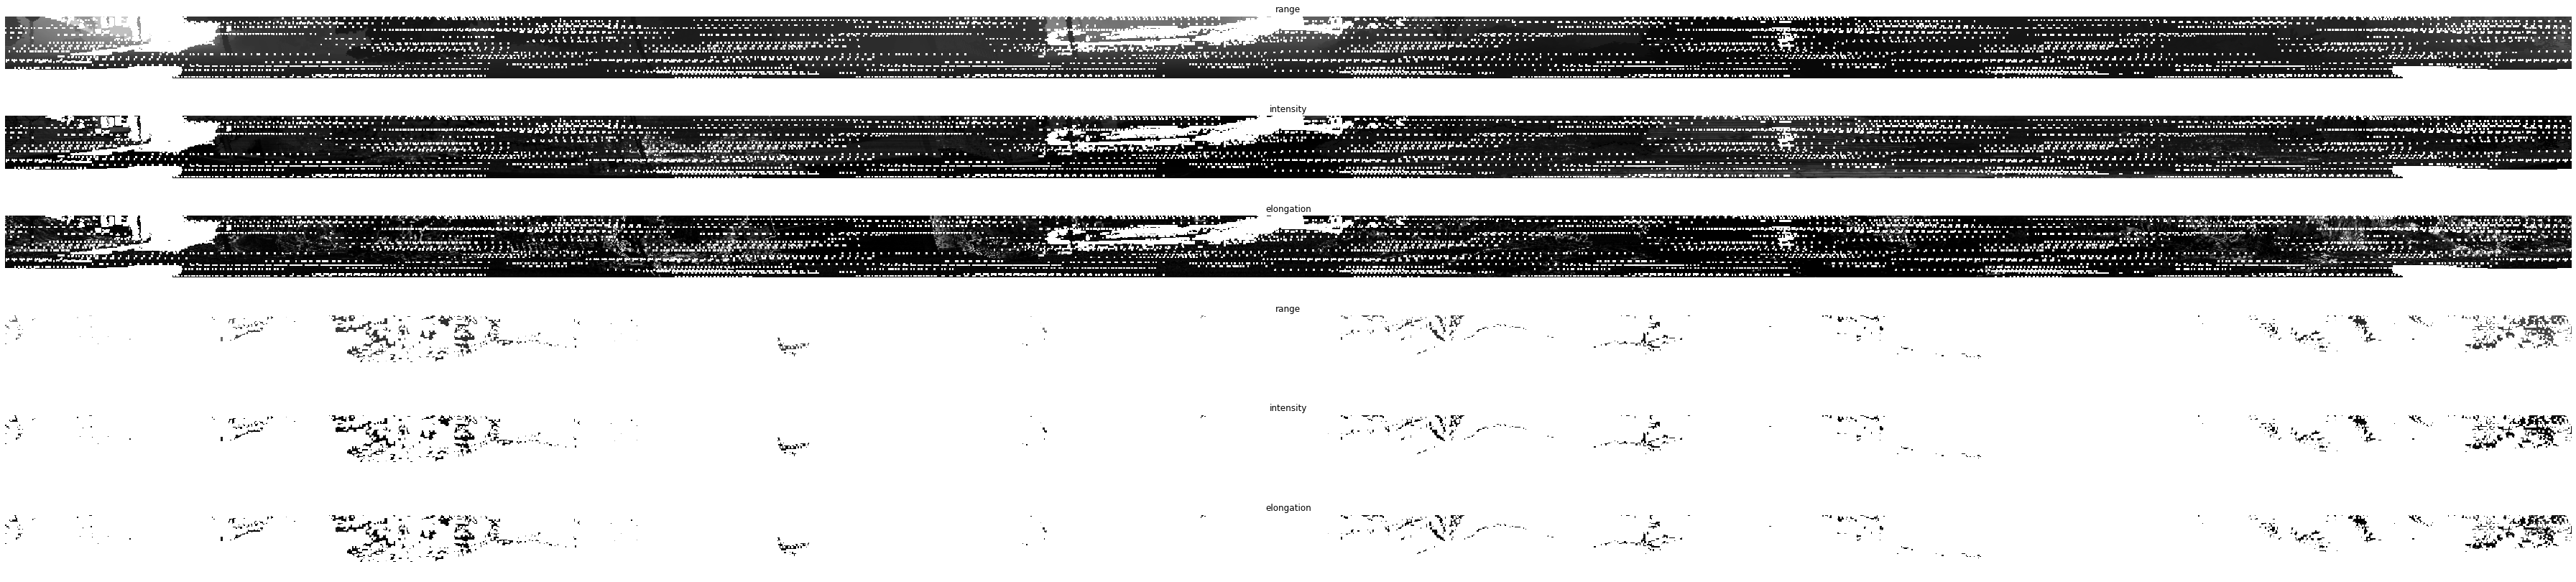

In [8]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_image(laser_name, return_index):
  """Returns range image given a laser name and its return index."""
  return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
  """Shows range image.

  Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
  """
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0] 
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
frames[0].lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

## Point Cloud Conversion

In [9]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

In [10]:
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(171606, 3)
(171606, 6)
[[-127.94089    -9.092773    5.839142]
 [-126.042114   -8.719727    5.594986]]
(153830, 3)
(153830, 6)
(3844, 3)
(3844, 6)
(3894, 3)
(3894, 6)
(4794, 3)
(4794, 6)
(5244, 3)
(5244, 6)


In [11]:
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
  print(points_ri2[i].shape)
  print(cp_points_ri2[i].shape)

(12074, 3)
(12074, 6)
[[-128.06342     -9.064453     5.8545837]
 [-128.09244     -8.672852     5.861389 ]]
(11340, 3)
(11340, 6)
(40, 3)
(40, 6)
(131, 3)
(131, 6)
(117, 3)
(117, 6)
(446, 3)
(446, 6)


In [12]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [13]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

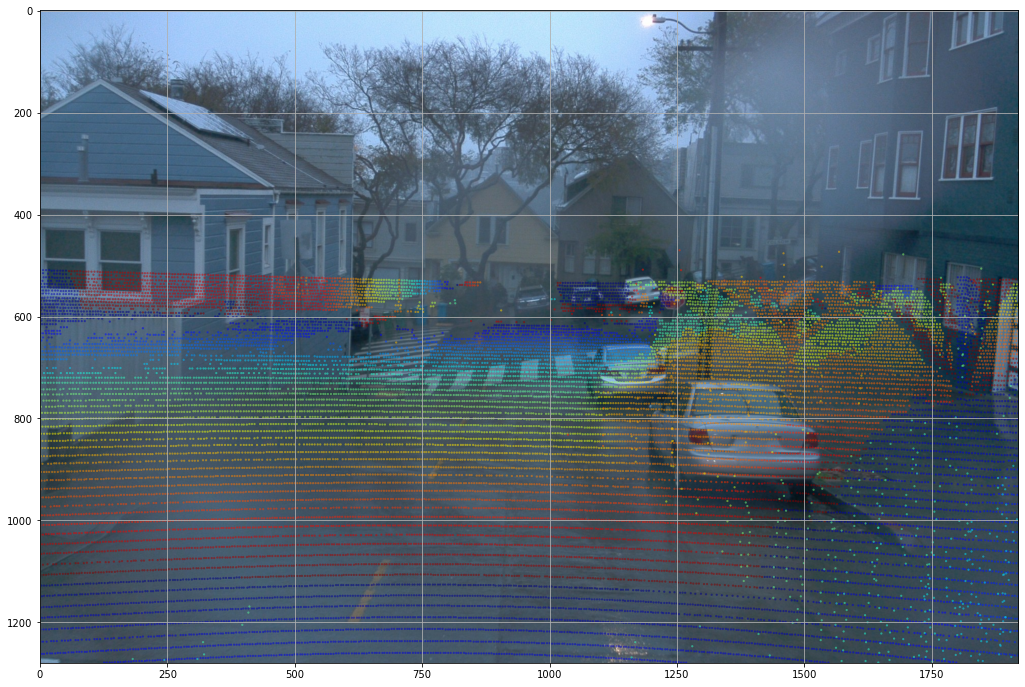

In [14]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)